In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
import csv
import numpy as np
import re
import random
import math
import time
import spacy

# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載字體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
!mv taipei_sans_tc_beta.ttf /usr/local/lib/python3.7/dist-packages/matplotlib//mpl-data/fonts/ttf

from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt 
plt.style.use("seaborn-whitegrid")
import matplotlib.ticker as ticker
# 自定義字體變數
myfont = FontProperties(fname=r'/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/taipei_sans_tc_beta.ttf')

--2021-03-28 09:24:39--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.142.100, 74.125.142.102, 74.125.142.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pe4mrkk4s15opeg3bpvr7jkalf2vv6nn/1616923425000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2021-03-28 09:24:39--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pe4mrkk4s15opeg3bpvr7jkalf2vv6nn/1616923425000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|74.125.

In [2]:
# 設定 torchtext 版本
!pip install torchtext==0.6.0
from torchtext.data import Field, BucketIterator, TabularDataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_dir = '/content/drive/My Drive/data/'
lines = open(data_dir + 'cmn.txt' , encoding='utf-8').read().strip().split('\n')
trnslt_pairs = [[s for s in l.split('\t')] for l in lines ]
print ("Sample: " , trnslt_pairs[1000][0:2] )
print ("Total records:" , len(trnslt_pairs))

Sample:  ['He was drowned.', '他被淹死了。']
Total records: 24360


In [5]:
# create train and validation set
trnslt_pairs = [pair for pair in trnslt_pairs if pair[1][0] in ['我','你','他','她']]
print (f"Total records: {len(trnslt_pairs)}")
train, test = train_test_split(trnslt_pairs, test_size=0.09)
train, val = train_test_split(train, test_size=0.08)
print (f"training data:{len(train)} , develop data: {len(val)} , testing data: {len(test)}")


def write_csv(trn_data, file_path):
    with open(file_path ,'w', newline='', encoding='utf-8') as fout:
        writer = csv.writer (fout)
        for itm in trn_data: 
            writer.writerow ([itm[0],itm[1]])
            
file_path = data_dir + 'train.csv'
write_csv(train, file_path )

file_path = data_dir + 'val.csv'
write_csv(val, file_path )
    
file_path = data_dir + 'test.csv'
write_csv(test, file_path )

Total records: 13420
training data:11235 , develop data: 977 , testing data: 1208


In [6]:
# 下載 spacy 的英文模型 幫我們做tokenize
spacy_eng = spacy.load('en_core_web_sm')

def tokensize_for_en(text):
    text = re.sub(r"([.!?])", r" \1", text)
    return [tok.text for tok in spacy_eng.tokenizer(text)]

def tokensize_for_ch(text):
    #去掉非中文字元
    regex = re.compile(r'[^\u4e00-\u9fa5A-Za-z0-9]')
    text = regex.sub(' ', text)

    return [word for word in text if word.strip()]

In [7]:
target_en = Field(tokenize = tokensize_for_en, 
                  init_token = '<sos>', eos_token = '<eos>', 
                  lower = True, batch_first = True)

source_ch = Field(tokenize = tokensize_for_ch, 
                  init_token = '<sos>', eos_token = '<eos>', 
                  lower = True, batch_first = True)

In [8]:
train_dataset, dev_dataset, test_dataset = TabularDataset.splits(
    path = data_dir , format = 'csv', skip_header = True,
    train='train.csv', validation='val.csv', test='test.csv',
    fields=[
        ('trg', target_en),
        ('src', source_ch)
    ]
)
source_ch.build_vocab(train_dataset, min_freq = 1)
target_en.build_vocab(train_dataset, min_freq = 1)

print ("中文語料的字元表長度: " , len(source_ch.vocab) , ", 英文的字元表長度: " ,len(target_en.vocab))
print ("Sample SRC:", test_dataset[0].src , "TRG:", test_dataset[0].trg)

中文語料的字元表長度:  2687 , 英文的字元表長度:  4104
Sample SRC: ['她', '把', '自', '己', '关', '在', '房', '里'] TRG: ['she', 'shut', 'herself', 'up', 'in', 'her', 'room', '.']


In [9]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
                                (train_dataset, dev_dataset, test_dataset), 
                                 batch_size = BATCH_SIZE,
                                 sort_within_batch = True,
                                 sort_key = lambda x : len(x.src),
                                 device = device)

In [10]:
# define encoder of transformer
class TransformerEncoder(nn.Module):
    def __init__(self, hidden_dim, feedforward_dim, n_enc_layers, 
                 n_attn_heads, dropout, src_voca_length, max_pos_length , 
                 device):
        """
        hidden_dim: embedding size
        feedforward_dim: feedforward 維度
        n_enc_layers: 幾層encoder layers
        n_attn_heads: 分成幾個attention
        dropout: dropout
        src_voca_length: 輸入的字典大小(此處為中文字典)
        max_pos_length: 設定的最大長度(做position embedding用)
        """
        super().__init__()
        self.device = device
        
        # 字元 embedding 
        self.src_tok_embedding = nn.Embedding(src_voca_length , hidden_dim) 
        
        # position embedding 
        self.src_pos_embedding = nn.Embedding(max_pos_length, hidden_dim)  
        
        # 建立 n_enc_layers 層的 Transformer Encoder 層
        self.transformer_encoder_layers = nn.ModuleList([TransformerEncoderLayer(
                                            hidden_dim, 
                                            feedforward_dim,
                                            n_enc_layers,
                                            n_attn_heads, 
                                            dropout, 
                                            device) for _ in range(n_enc_layers)])

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src_sentence, src_mask):
        """
        src_sentence: [batch_size, src_len]
        src_mask: [batch_size, src_len]
        """
        
        batch_size = src_sentence.shape[0]
        src_len = src_sentence.shape[1]
        
        # 產生 position embedding數列 
        # [batch_size, src_len]
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        # 將 token embedding 和 position embedding 相加
        # src_sentence [batch_size, src_len, hid_dim]
        src_sentence = self.dropout(self.src_tok_embedding(src_sentence) + self.src_pos_embedding(pos))

        # 將 src_sentence 輸入 n_enc_layers 層的 transformer encoder layers 
        for layer in self.transformer_encoder_layers:
            encoder_hidden, encoder_self_attention = layer(src_sentence, src_mask)
            
        # 輸出最後一層的 hidden layer and encoder self attention    
        # encoder_hidden [batch_size, src_len, hid_dim]
        # encoder_self_attention [batch_size , attention_heads, src_len, src_len]

        return encoder_hidden , encoder_self_attention

In [11]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, hidden_dim , feedforward_dim, n_enc_layers, n_attn_heads, dropout , device):
        """
        hidden_dim: embedding size
        feedforward_dim: feedforward 維度
        """
        super().__init__()
        
        # 建立 Multi Head self Attention
        self.self_attention_sublayer = MultiHeadAttentionSubLayer(hidden_dim, n_attn_heads, dropout, device)
        
        # layer norm
        self.self_attn_layernorm = nn.LayerNorm(hidden_dim)

        # 建立 Position Wise Feedforward
        self.feedforward_sublayer = PosFeedForwardSubLayer(hidden_dim,feedforward_dim,dropout)
        
        # layer norm
        self.feedforward_layernorm = nn.LayerNorm(hidden_dim)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, src_embedding, src_mask):
        """
        src_embedding: [batch_size, src_len, hid_dim]
        src_mask: [batch_size, src_len]
        """

        # 將 K Q V 計算 attention
        _src,  encoder_self_attention = self.self_attention_sublayer(src_embedding, src_embedding, src_embedding, src_mask)

        # dropout, residual 殘差 connection and layer norm
        # src_embedding [batch_size, src_len, hid_dim]
        src_embedding = self.self_attn_layernorm(src_embedding + self.dropout(_src))

        # positionwise feedforward
        _src = self.feedforward_sublayer(src_embedding)

        #dropout, residual 殘差 and layer norm
        src_embedding = self.feedforward_layernorm(src_embedding + self.dropout(_src))

        # 輸出 src_sentence hidden layer 和 encoder_self_attention
        # src_embedding [batch_size, src_len, hid_dim]
        # encoder_self_attention [batch_size, attension_heads, src_len, src_len]
        
        return src_embedding , encoder_self_attention

In [12]:
class MultiHeadAttentionSubLayer(nn.Module):
    def __init__(self, hidden_dim , n_attn_heads, dropout, device):
        """
        hidden_dim: embedding size
        n_attn_heads: 分成幾個attention
        dropout: dropout
        """
        super().__init__()

        # 確定 設定的 hidden layer 維度可以被 attention head 整除
        assert hidden_dim % n_attn_heads ==0

        # hidden layer 維度
        self.hidden_dim = hidden_dim
        
        # multi-heads 的個數
        self.n_attn_heads = n_attn_heads
        
        # 平均分到每個 multi-head 的 維度
        self.head_dim = hidden_dim // n_attn_heads
        
        # 定義 Wq Wk Wv
        self.full_conn_q = nn.Linear(hidden_dim, hidden_dim)
        self.full_conn_k = nn.Linear(hidden_dim, hidden_dim)
        self.full_conn_v = nn.Linear(hidden_dim, hidden_dim)


        # 最後一層 線性轉換
        self.full_conn_o = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout)
        
        # 根據維度大小調整 attention 值 以免維度太大 Q dot K 結果過大影響學習效率    
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query_input, key_input, value_input, mask = None):
        """
        query_input: q [batch_size, q_len, hid_dim]
        key_input: q [batch_size, k_len, hid_dim]
        value_input: q [batch_size, v_len, hid_dim]
        """
        batch_size = query_input.shape[0]
        
        # 定義 WQ*q -> Q WK*k -> K WV*v -> V
        # Q [batch size, query len, hid dim]
        # K [batch size, key len, hid dim]
        # V [batch size, value len, hid dim]
        Q = self.full_conn_q(query_input)
        K = self.full_conn_k(key_input)
        V = self.full_conn_v(value_input)

        # 將 attention 分成多個 attention
        def split_attention(Q, K, V, num_atn_head, head_dim, batch_size):
            Q = Q.view(batch_size, -1, num_atn_head, head_dim)
            K = K.view(batch_size, -1, num_atn_head, head_dim)
            V = V.view(batch_size, -1, num_atn_head, head_dim)
            return Q, K, V

        # 將 attention 的 2 和 3 維度轉置 以達到將 attention head 提到前面 而分開每個 attention head
        def seperate_heads(Q, K, V):
            Q = Q.permute(0, 2, 1, 3) # (batch_size, num_atn_head, query_len, head_dim)
            K = K.permute(0, 2, 1, 3) # (batch_size, num_atn_head, key_len, head_dim)
            V = V.permute(0, 2, 1, 3) # (batch_size, num_atn_head, value_len, head_dim)
            return Q , K , V


        Q, K, V = split_attention(Q, K, V, self.n_attn_heads, self.head_dim, batch_size)
        Q, K, V = seperate_heads (Q, K, V)

        # 將Ｋ的最後兩個維度轉置做 Q * K 除以 scale
        # scaled_dot_product_similarity [batch_size, n_heads, query_len, key_len]
        scaled_dot_product_similarity = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # 做 mask
        if mask is not None:
            scaled_dot_product_similarity = scaled_dot_product_similarity.masked_fill(mask == 0, -1e10)
        
        # 隊最後一維做 softmax attention [batch_size, n_heads, query_len, key_len]
        attention = torch.softmax(scaled_dot_product_similarity, dim = -1)
        
        # 最後與 V 相乘
        # x [batch_size, n_heads, query_len, head_dim]
        x = torch.matmul(self.dropout(attention), V)
        
        # 轉換維度 準備將attention合併 x [batch_size, query_len, n_heads, head_dim]
        x = x.permute(0, 2, 1, 3).contiguous()
        #x [batch_size, query_len, hid_dim]
        x = x.view(batch_size, -1, self.hidden_dim)
        
        # 執行最後一層 x [batch_size, query_len, hid_dim]
        x = self.full_conn_o(x)
        
        return x, attention

In [13]:
class PosFeedForwardSubLayer(nn.Module):
    def __init__(self, hidden_dim, ff_dim, dropout):
        super().__init__()
        self.full_conn_1 = nn.Linear(hidden_dim, ff_dim)
        
        self.full_conn_2 = nn.Linear(ff_dim,  hidden_dim)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        """
        x: [batch_size, seq_len, hid_dim]
        """

        # x [batch_size, seq_len, ff_dim]
        x = self.dropout(torch.relu(self.full_conn_1(x)))
        
        # x [batch_size, seq_len, hid_dim]
        x = self.full_conn_2(x)
        
        return x

In [14]:
class TransformerDecoder(nn.Module):
    def __init__(self, hidden_dim, feedforward_dim, n_dec_layers, n_attn_heads, dropout, 
                 dec_voca_length, max_pos_length , device , skip_encoder_attn = False):
        """
        hidden_dim: embedding 大小
        feedforward_dim: feedforward大小
        n_dec_layers: 幾個 decoder Layers
        n_attn_heads: 幾個 attention
        dropout: dropout
        dec_voca_length: 輸出的字典大小(英文)
        max_pos_length: dec_max_len
        """
        super().__init__()
        self.device = device

        # token embedding 
        self.dec_tok_embedding = nn.Embedding(dec_voca_length, hidden_dim)
        
        # position embedding 
        self.dec_pos_embedding = nn.Embedding(max_pos_length, hidden_dim)

        # 建立 n_dec_layers 個 TransformerDecoderLayer 層
        self.transformer_decoder_layers = nn.ModuleList([TransformerDecoderLayer(
                                          hidden_dim,
                                          feedforward_dim, 
                                          n_dec_layers,
                                          n_attn_heads,
                                          dropout, 
                                          device, skip_encoder_attn) for _ in range(n_dec_layers)])

        # 輸出層 輸出 vocabulary 個長度
        self.full_conn_out = nn.Linear(hidden_dim, dec_voca_length)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, dec_seq, enc_hidden , dec_mask, enc_mask):
        """
        dec_seq: [batch_size, trg_len]
        enc_hidden: [batch_size, src_len, hid_dim]
        dec_mask: [batch_size, trg_len]
        enc_mask: [batch_size, src_len]
        """
        
        batch_size = dec_seq.shape[0]
        dec_len = dec_seq.shape[1]
        # pos [batch_size, trg_len]
        pos = torch.arange(0, dec_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        # 將 decoder token embedding 加上 decoder postion embedding
        # dec_seq [batch_size, trg_len, hid_dim]
        dec_seq = self.dropout(self.dec_tok_embedding(dec_seq) + self.dec_pos_embedding(pos))
                

        for layer in self.transformer_decoder_layers:
            dec_seq, encoder_decoder_attention , decoder_self_attention = layer(dec_seq, enc_hidden, dec_mask, enc_mask)
        
        #dec_seq 輸出 tensor 形狀 [batch_size, trg_len, hid_dim]
        #attention 輸出 tensor 形狀 [batch_size, n_heads, trg_len, src_len]
        
        output = self.full_conn_out(dec_seq)

        #output tensor 形狀 [batch size, trg len, output dim]

        return output, encoder_decoder_attention , decoder_self_attention


In [15]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, hidden_dim, feedforward_dim, n_dec_layers, n_attn_heads, dropout, device, skip_encoder_attn=False):
        """
        hidden_dim: embedding 大小
        feedforward_dim: feedforward大小
        n_dec_layers: 幾個 decoder Layers
        n_attn_heads: 幾個 attention
        dropout: dropout
        """
        super().__init__()

        self.skip_encoder_attn = skip_encoder_attn 

        self.self_attention_sublayer = MultiHeadAttentionSubLayer(hidden_dim, n_attn_heads, dropout, device)
        self.self_attn_layernorm = nn.LayerNorm(hidden_dim)

        if not skip_encoder_attn:
            self.encoder_attention_sublayer = MultiHeadAttentionSubLayer(hidden_dim, n_attn_heads, dropout, device)
            self.encoder_attn_layernorm = nn.LayerNorm(hidden_dim)

        self.positionwise_feedforward = PosFeedForwardSubLayer(hidden_dim,feedforward_dim ,dropout)
        
        self.feedforward_layernorm = nn.LayerNorm(hidden_dim)

        self.dropout = nn.Dropout(dropout)     

    def forward(self, dec_seq, enc_hidden , dec_mask, enc_mask):
        """
        dec_seq: [batch_size, trg_len, hid_dim]
        enc_hidden: [batch_size, src_len, hid_dim]
        dec_mask: [batch_size, trg_len]
        enc_mask: [batch_size, src_len]
        """
        
        # self attention 子層
        _dec_seq, decoder_self_attention = self.self_attention_sublayer(dec_seq, dec_seq, dec_seq, dec_mask)
        
        # dropout, residual connection and layer norm
        # dec_seq  輸出 tensor 形狀 [batch_size, trg_len, hid_dim] => decoder的 q
        dec_seq = self.self_attn_layernorm(dec_seq + self.dropout(_dec_seq))
            
        # 需不需要建立　encoder attention 層        
        if not self.skip_encoder_attn:
            #encoder attention
            _dec_seq, encoder_decoder_attention = self.encoder_attention_sublayer(dec_seq, enc_hidden, enc_hidden, enc_mask)
          
            # dropout, residual connection and layer norm
            # dec_seq [batch_size, trg_len, hid_dim]
            dec_seq = self.encoder_attn_layernorm(dec_seq + self.dropout(_dec_seq))
        else:
            encoder_decoder_attention = None
                    
        # positionwise feedforward
        _dec_seq = self.positionwise_feedforward(dec_seq)
        
        #dropout, residual and layer norm
        dec_seq = self.feedforward_layernorm(dec_seq + self.dropout(_dec_seq))
        
        # dec_seq [batch_size, trg_len, hid dim]
        # attention [batch_size, n_heads, trg_len, src_len]
        
        return dec_seq, encoder_decoder_attention , decoder_self_attention
        


In [16]:
class Transformer(nn.Module):
    def __init__(self,encoder, decoder, src_pad_idx, trg_pad_idx, device):
        """
        encoder: Transformer encoder
        decoder: Transformer decoder
        src_pad_idx: encoder padding index  
        trg_pad_idx: decoder padding index 
        """
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        """
        src: [batch size, src len]
        """
        # 做Padding mask的準備 讓attention對padding的idx影響變小
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # src_mask [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):
        """
        trg: [batch size, trg len]
        """
        # Padding mask
        # trg_pad_mask [batch size, 1, 1, trg len]
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
          
        trg_len = trg.shape[1]
        
        # Look ahead mask
        #trg_sub_mask = [trg len, trg len]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_mask = [batch size, 1, trg len, trg len]
        trg_mask = trg_pad_mask & trg_sub_mask
        
    
        return trg_mask

    def forward(self, src, trg):
        """
        src [batch size, src len]
        trg [batch size, trg len]
        """
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        #src_mask = [batch size, 1, 1, src_len]
        #trg_mask = [batch size, 1, trg_len, trg_len]
        
        # enc_src = [batch_size, src_len, hid_dim]
        enc_src , encoder_self_attention = self.encoder(src, src_mask)
        
    
                
        output, encoder_decoder_attention , decoder_self_attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch_size, trg_len, output_dim]
        #attention = [batch_size, n_heads, trg_len, src_len]

        return output, encoder_decoder_attention , encoder_self_attention ,  decoder_self_attention

In [17]:
INPUT_DIM = len(source_ch.vocab)
OUTPUT_DIM = len(target_en.vocab)
MAX_SENT_LENGTH = 40
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_FF_DIM = 512
DEC_FF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

LEARNING_RATE = 0.0005

SRC_PAD_IDX = source_ch.vocab.stoi[source_ch.pad_token]
TRG_PAD_IDX = target_en.vocab.stoi[target_en.pad_token]


enc = TransformerEncoder(HID_DIM, ENC_FF_DIM, ENC_LAYERS, ENC_HEADS, ENC_DROPOUT,INPUT_DIM,  MAX_SENT_LENGTH,device)

dec = TransformerDecoder(HID_DIM, DEC_FF_DIM,
              DEC_LAYERS, 
              DEC_HEADS,  
              DEC_DROPOUT, 
              OUTPUT_DIM, MAX_SENT_LENGTH,
              device)



model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [18]:
print ("Total model parameters {:0.0f}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

Total model parameters 6767368


In [19]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ , _ , _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [20]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ , _ , _= model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [21]:
model_dir =  '/content/drive/My Drive/data/transformerModel/'

In [22]:
N_EPOCHS = 30
CLIP = 1

best_valid_loss = 9999999

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    #epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    torch.save(model.state_dict(), model_dir + 'model-{}.pt'.format(epoch))
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_dir + 'best-model.pt')
    
    print ("Epoch {} training time: {:.2f} sec Training Loss: {:.3f} , Valiation Loss: {:.3f}".format( epoch , end_time - start_time , train_loss , valid_loss))
 


Epoch 0 training time: 3.42 sec Training Loss: 5.092 , Valiation Loss: 4.218
Epoch 1 training time: 3.49 sec Training Loss: 3.865 , Valiation Loss: 3.668
Epoch 2 training time: 3.61 sec Training Loss: 3.321 , Valiation Loss: 3.215
Epoch 3 training time: 3.65 sec Training Loss: 2.856 , Valiation Loss: 2.876
Epoch 4 training time: 3.54 sec Training Loss: 2.512 , Valiation Loss: 2.638
Epoch 5 training time: 3.67 sec Training Loss: 2.223 , Valiation Loss: 2.446
Epoch 6 training time: 3.64 sec Training Loss: 1.963 , Valiation Loss: 2.323
Epoch 7 training time: 3.61 sec Training Loss: 1.742 , Valiation Loss: 2.229
Epoch 8 training time: 3.57 sec Training Loss: 1.553 , Valiation Loss: 2.097
Epoch 9 training time: 3.74 sec Training Loss: 1.385 , Valiation Loss: 2.053
Epoch 10 training time: 3.66 sec Training Loss: 1.237 , Valiation Loss: 1.984
Epoch 11 training time: 3.67 sec Training Loss: 1.101 , Valiation Loss: 1.960
Epoch 12 training time: 3.66 sec Training Loss: 0.981 , Valiation Loss: 1.

In [23]:
# Save SRC and TRG vocab
torch.save(source_ch.vocab, model_dir + 'SRC_vocab.pt')
torch.save(target_en.vocab, model_dir + 'TRG_vocab.pt')

!nvidia-smi


Sun Mar 28 09:21:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    45W /  70W |   2288MiB / 15109MiB |     27%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
model_dir =  '/content/drive/My Drive/data/transformerModel/'
model.load_state_dict(torch.load(model_dir + 'best-model.pt'))
#model.load_state_dict(torch.load(model_dir + 'model-8.pt'))
test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} |')

| Test Loss: 1.951 |


In [25]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    tokens = [token.lower() for token in sentence]
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src , encoder_self_attention = model.encoder(src_tensor, src_mask)

    # 翻譯結果句 先以 init token 開頭
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, encoder_decoder_attention , decoder_self_attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        # 取得模型最佳預測
        pred_token = output.argmax(2)[:,-1].item()
        # 放入翻譯結果句 
        trg_indexes.append(pred_token)
        # 碰到 eos 結束 
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], encoder_decoder_attention , encoder_self_attention , decoder_self_attention

In [26]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        #translation, attention = translate_sentence(src, SRC, TRG, model, device)

        pred_trg, _ ,_ ,_= translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

bleu_score = calculate_bleu(test_dataset, source_ch, target_en, model, device)

print(f'BLEU score of test dataset = {bleu_score*100:.2f}')

BLEU score of test dataset = 28.59


In [27]:
def plot_attention(sentence1 , sentence2, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    fig = plt.figure(figsize=(15,25))
    for i in range(n_heads):    
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()
        cax = ax.matshow(_attention, cmap='bone')
        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+sentence1, 
                           rotation=45,fontproperties=myfont)
        ax.set_yticklabels(['']+sentence2,fontproperties=myfont)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

def plot_attention_summary(sentence1, sentence2, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attn_summary = np.sum(attention.squeeze(0).cpu().detach().numpy()  , axis=0)
    cax = ax.matshow(attn_summary, cmap='bone')
    
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+sentence1, 
                       rotation=45 , fontproperties=myfont) #, fontdict=fontdict)
    ax.set_yticklabels(['']+sentence2, fontproperties=myfont) # , fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()


In [28]:
sample_index = 1250
src = vars(train_dataset.examples[sample_index])['src']
trg = vars(train_dataset.examples[sample_index])['trg']

print('src = ' , src)
print('trg = ' , trg)

translation, encoder_decoder_attention , encoder_self_attention , decoder_self_attention = translate_sentence(src, source_ch, target_en, model, device)

print('翻譯  = ' ,translation)

src =  ['你', '为', '什', '么', '会', '认', '为', '我', '在', '想', '你']
trg =  ['why', 'do', 'you', 'think', 'i', "'m", 'thinking', 'about', 'you', '?']
翻譯  =  ['why', 'do', 'you', 'think', 'i', "'m", 'thinking', 'about', 'you', '?', '<eos>']


# [作業重點] 繪製 encoder and decoder attention 
## encoder_decoder_attention 是 transformer decoder 最後一層的attention 值
## Summary 是把 8 個 attention head 的結果累加
## 這邊的結果可以和 RNN-attention 的結果來對比
## 來原句前後要加 sos and eos
## 請將你的觀察寫在這邊:
## 觀察

為什麼與why有關注到其重要性
都有注意到對應的字 前後的you也知道其順序性

你为什么会认为我在想你 torch.Size([1, 8, 11, 13])


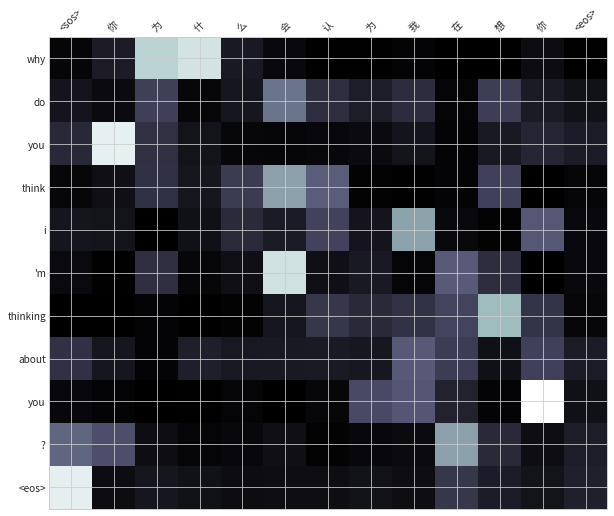

In [37]:
print ("".join(src ) , encoder_decoder_attention.shape)

plot_attention_summary(['<sos>']+src+['<eos>']  , translation , encoder_decoder_attention)

# [作業重點] 繪製 encoder and decoder attention 
## encoder_decoder_attention 是 transformer decoder 最後一層的attention 值
## 把八個 attention 分開繪製
## 來原句前後要加 sos and eos
## 請將你的觀察寫在這邊:
## 觀察
有些head注意到的是句子的前半段/中間/後半段
感覺是分別注意每個字的attention值

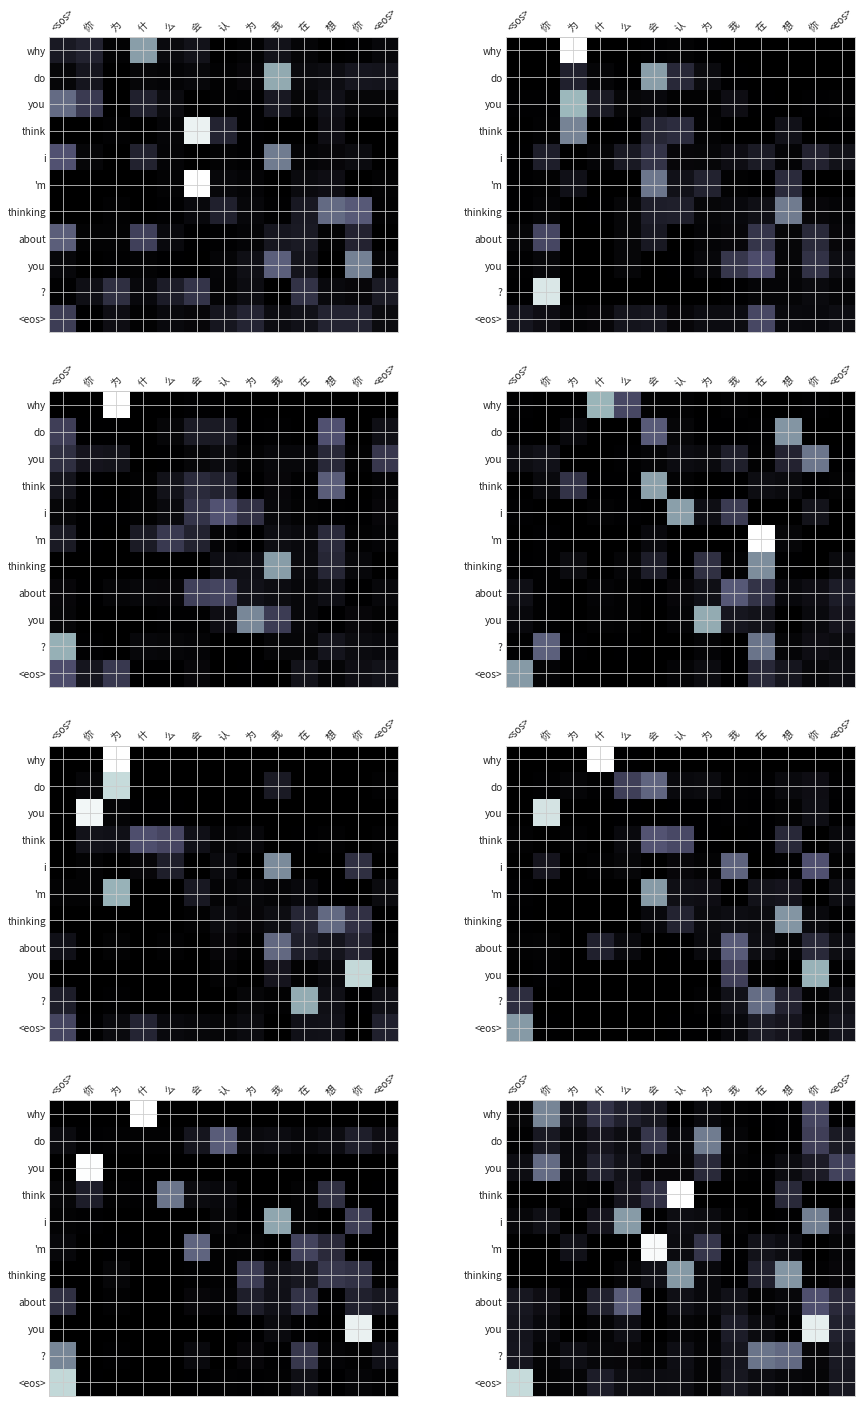

In [38]:
plot_attention(['<sos>']+src+['<eos>']  , translation , encoder_decoder_attention)

# [作業重點] 繪製 encoder self attention 
## encoder_self_attention 是 transformer encoder 最後一層的 self attention 值
## Summary 是把 8 個 attention head 的結果累加
## 來原句前後要加 sos and eos
## 請將你的觀察寫在這邊:
## 觀察
自己對自己做attention有大概得到其關係性(為與你的關係就不好)

你为什么会认为我在想你 torch.Size([1, 8, 13, 13])


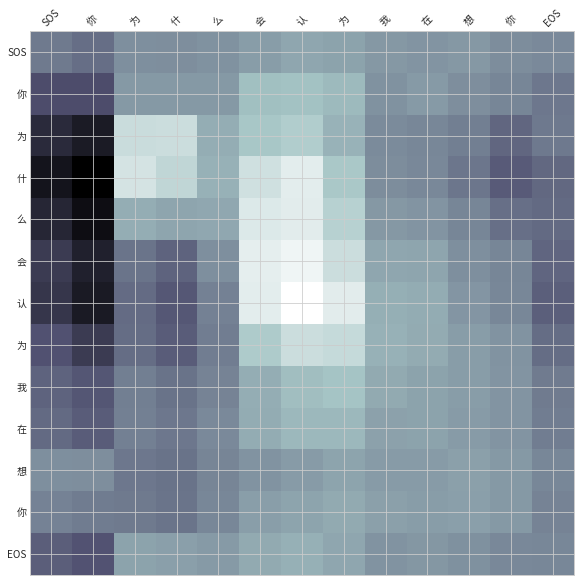

In [39]:
print ("".join(src ) , encoder_self_attention.shape)

plot_attention_summary(['SOS'] + src + ['EOS'] , ['SOS'] + src + ['EOS'] ,  encoder_self_attention)

# [作業重點] 繪製 encoder self attention 
## encoder_self_attention 是 transformer encoder 最後一層的 self attention 值
## 把八個 attention 分開繪製
## 來原句前後要加 sos and eos
## 請將你的觀察寫在這邊:
## 觀察
encoder好像無法完全抓到自己對自己的重要性
但還是有，與最後的encoder_decoder_attention一樣
感覺是分別注意每個字的attention值

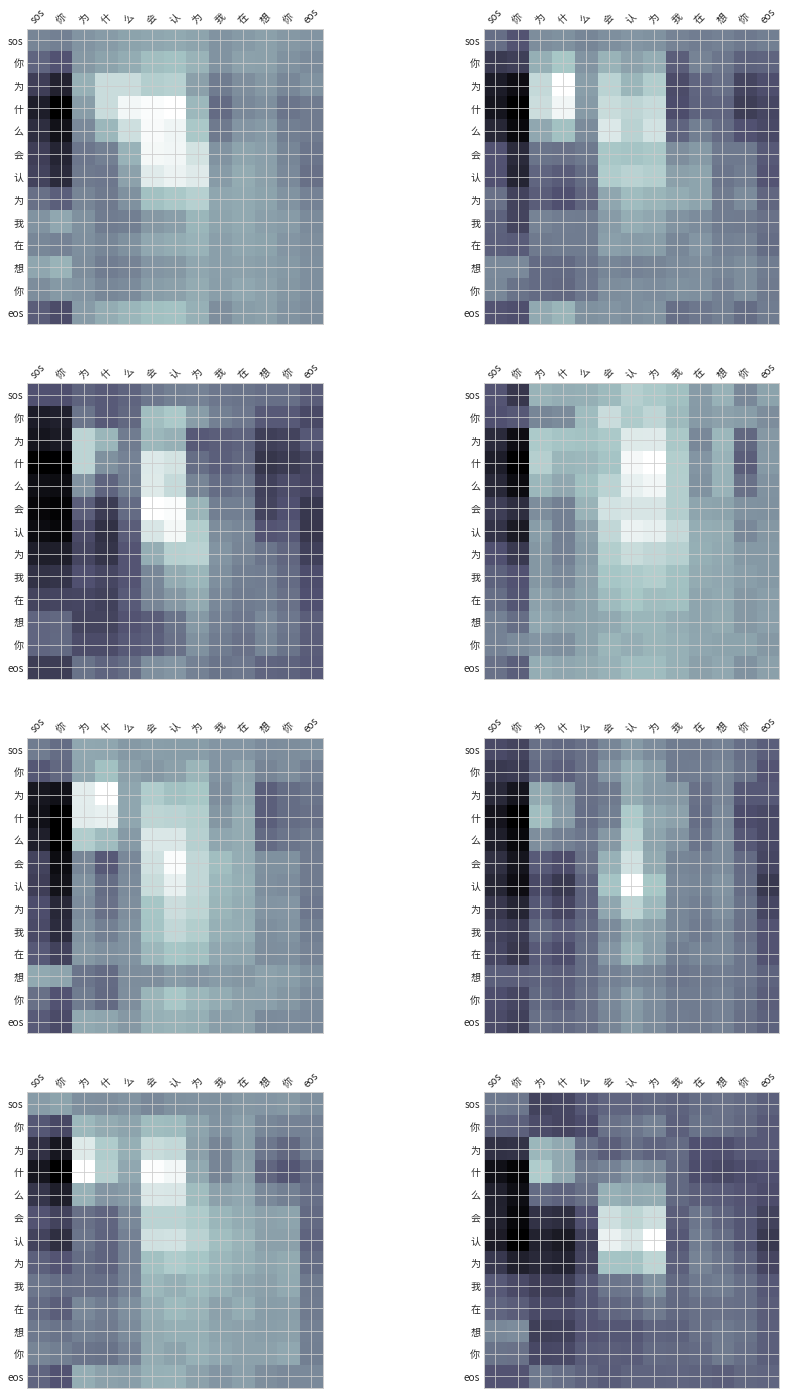

In [40]:
plot_attention(['sos'] + src + ['eos'] , ['sos'] + src + ['eos'] , encoder_self_attention)

# [作業重點] 繪製 decoder self attention 
## decoder_self_attention 是 transformer decoder 最後一層的 self attention 值
## 被attention 的翻譯句 前要加 sos
## 請將你的觀察寫在這邊:
## 觀察
decoder的attention的值就不錯
猜測是因為有對自己做look-ahead mask
所以訓練完比較強

你为什么会认为我在想你 torch.Size([1, 8, 11, 11])


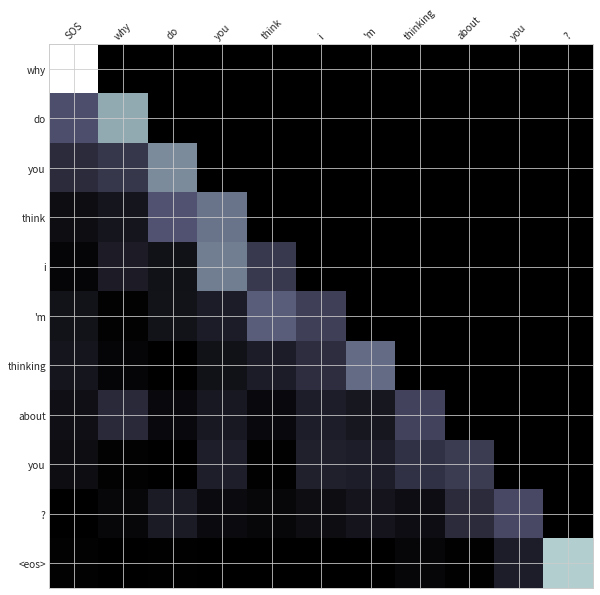

In [41]:
print ("".join(src ), decoder_self_attention.shape)

plot_attention_summary(['SOS'] + translation  , translation ,  decoder_self_attention)

# [作業重點] 繪製 decoder self attention 
## decoder_self_attention 是 transformer decoder 最後一層的 self attention 值
## 把八個 attention heads 分開繪製
## 被attention 的翻譯句 前要加 sos
## 請將你的觀察寫在這邊:
## 觀察
每個decoder的attention的值就不錯
猜測是因為有對自己做look-ahead mask
所以訓練完比較強

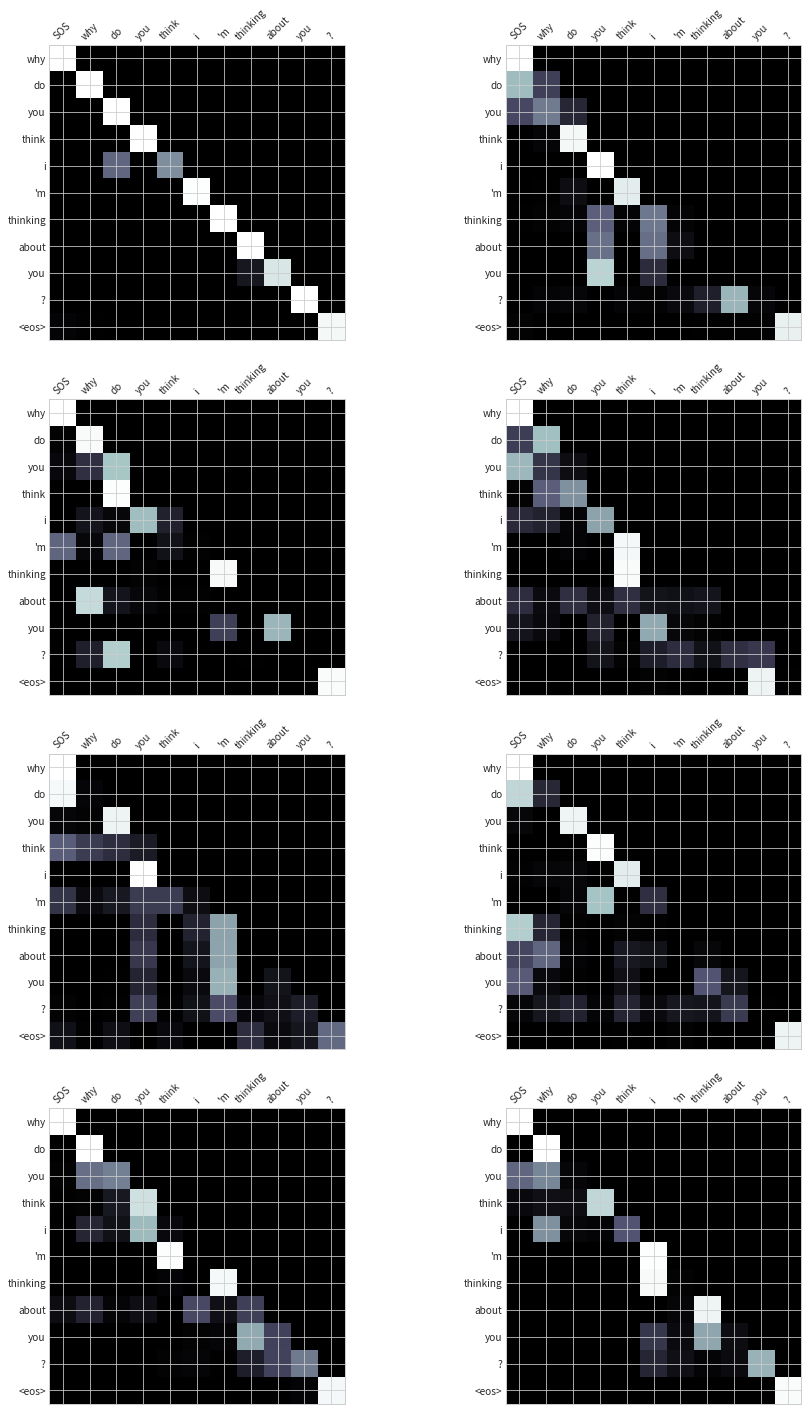

In [42]:
plot_attention(['SOS'] + translation , translation, decoder_self_attention)